#### In this notebook I am building a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

###### Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive.

In [1]:
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#settings

color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "one"

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('train.csv').fillna(' ')
test = pd.read_csv('test.csv').fillna(' ')

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

In [2]:
train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [3]:
train_text.head()
train_text[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [4]:
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
train['clean'].sum()

143346

C:\Users\omistaja\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


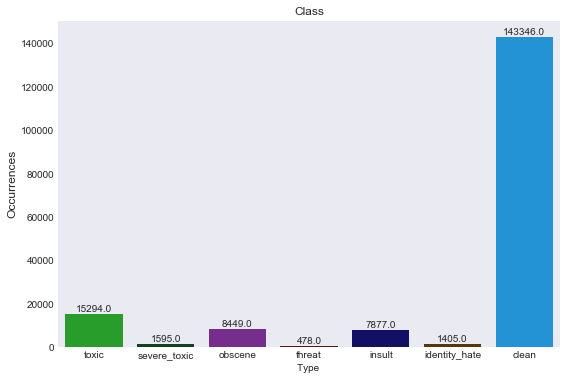

In [5]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

colors_list = ["green", "pine green", "purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=train.iloc[:,2:].sum()

plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

#### We have more than 143k clean comments that results in an unbalanced dataset. This should be taken into account as predicting only clean will yield high accuracy, but low recall and f1-score. 

In [6]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')

### 1. Regular Expressions

In [8]:
import re
from nltk.corpus import stopwords
import string
eng_words = stopwords.words('english')
def word_tokenize(x):
    regex = re.compile('['+re.escape(string.punctuation)+'0-9\\n\\t]')
    text = regex.sub(' ',x)
    words = [word for word in text.split(' ') if len(word)>=1]
    words = [word.lower() for word in words if word not in eng_words]
    return words

In [ ]:
# Advanced Regular Expressions

def prepare_for_char_n_gram(text):
    # 1. Go to lower case 
    clean = bytes(text.lower(), encoding="utf-8")
    # 2. Drop \n and  \t
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    # 3. Replace english contractions
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    # 4. Drop puntuation
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    # 5. Drop numbers 
    clean = re.sub(b"\d+", b" ", clean)
    # 6. Remove extra spaces - At the end of previous operations we multiplied space accurences
    clean = re.sub(b'\s+', b' ', clean)
    # Remove ending space if any
    clean = re.sub(b'\s+$', b'', clean)
    # 7. Now replace words by words surrounded by # signs
    clean = re.sub(b" ", b"# #", clean)  # Replace space
    clean = b"#" + clean + b"#"  # add leading and trailing

    return str(clean, 'utf-8')

### Visualisation

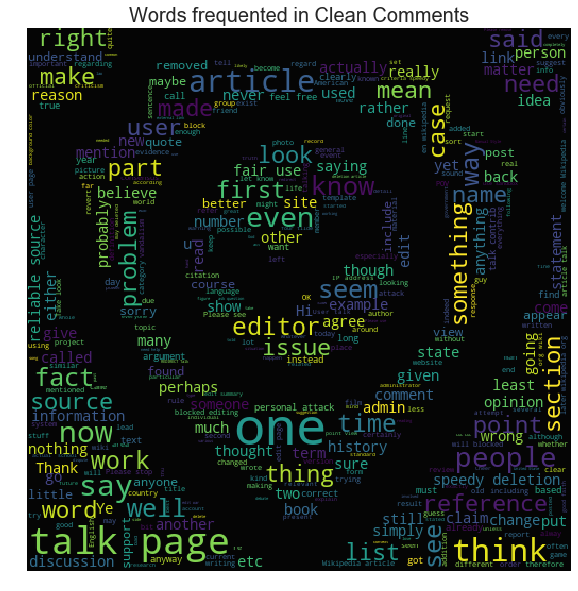

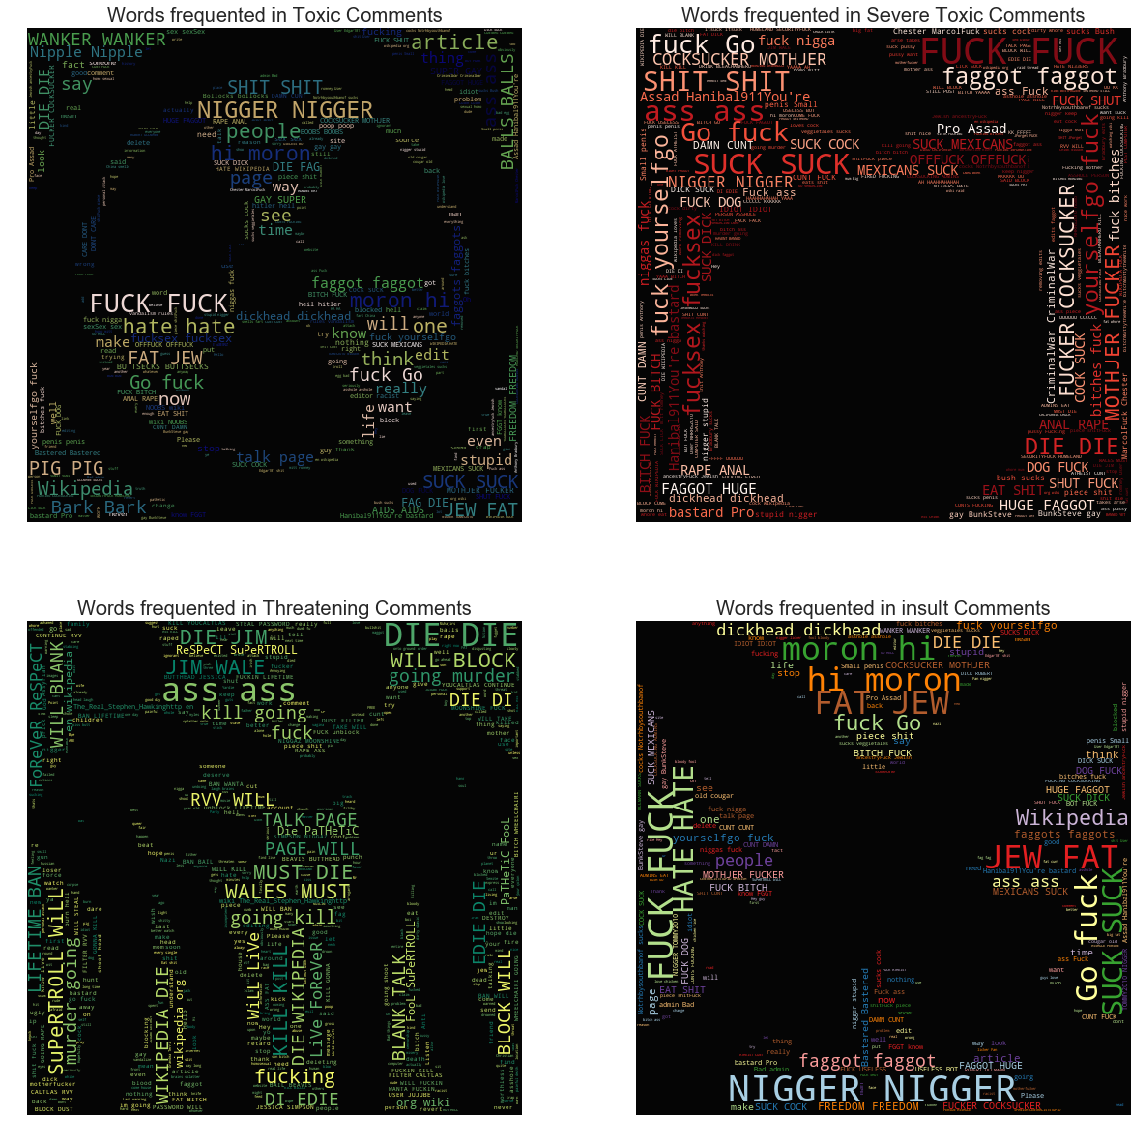

In [9]:


#clean comments
clean_mask=np.array(Image.open("input/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)

stopword=set(STOPWORDS)
toxic_mask=np.array(Image.open("input/toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("input/bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("input/anger.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("input/swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

In [10]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)
corpus=merge.comment_text


In [11]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [12]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup 
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)

    return(clean_sent)

In [13]:
clean_corpus=corpus.apply(lambda x :clean(x))


## 2. Language Modeling


#### Preperation for visualsing unigrams and bigrams

In [14]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [15]:
import warnings
warnings.filterwarnings("ignore")

#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [16]:
tfv = TfidfVectorizer(min_df=200,  max_features=100, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)


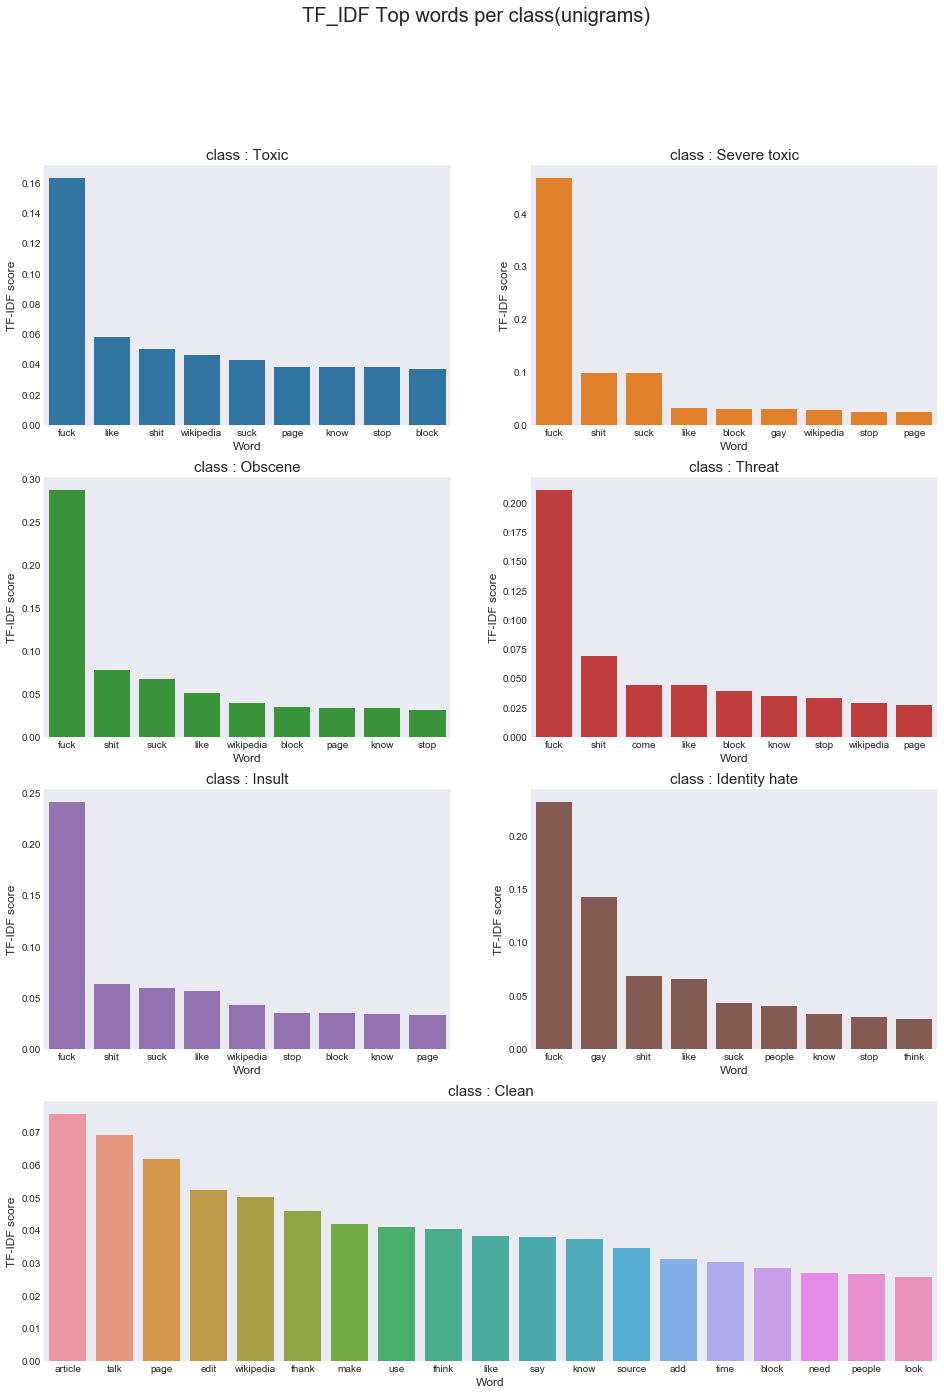

In [17]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [18]:


tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

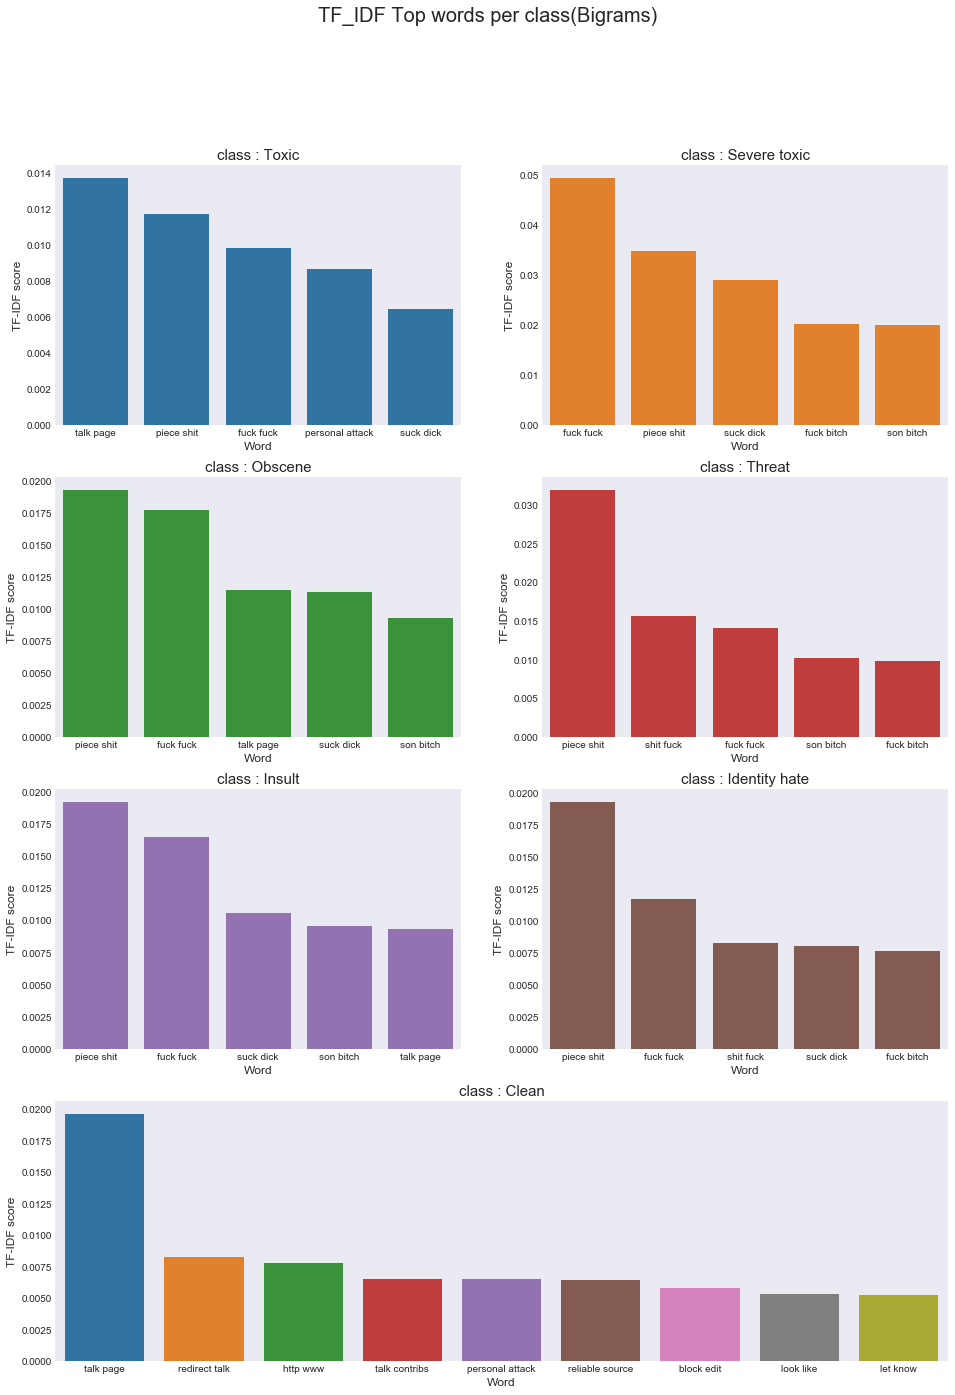

In [19]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

## 3. Text Segmentation

In [20]:
import pyLDAvis
import pyLDAvis.gensim
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
pyLDAvis.enable_notebook()

C:\Users\omistaja\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [21]:
def preprocess(comment):
    """
    Function to build tokenized texts from input comment
    """
    return gensim.utils.simple_preprocess(comment, deacc=True, min_len=3)

In [22]:
train_text=train.comment_text.apply(lambda x: preprocess(x))
test_text=test.comment_text.apply(lambda x: preprocess(x))
all_text=train_text.append(test_text)

In [23]:
#all_text=all_text.apply(lambda x:clean(x))


In [24]:
dictionary = Dictionary(all_text)
print("There are",len(dictionary),"number of words in the final dictionary")

There are 312425 number of words in the final dictionary


In [25]:
corpus = [dictionary.doc2bow(text) for text in all_text]


In [26]:
#create the LDA model
ldamodel = LdaModel(corpus=corpus, num_topics=15, id2word=dictionary)


In [27]:
bigram = gensim.models.Phrases(all_text)


In [28]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)


C:\Users\omistaja\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      19.661097        1       1 -0.228598  0.007999
8      18.685249        1       2 -0.227564 -0.026124
13     11.199132        1       3 -0.142064  0.166910
5      11.033074        1       4 -0.192618 -0.089688
12      9.106297        1       5 -0.133341  0.153515
3       6.877011        1       6 -0.086956 -0.150993
4       4.715224        1       7 -0.099438 -0.142416
1       4.114828        1       8 -0.110305  0.090184
6       3.084654        1       9 -0.091898  0.107399
10      2.652267        1      10 -0.014643 -0.169937
14      2.150861        1      11  0.159847 -0.072031
11      1.799580        1      12  0.257807 -0.071844
9       1.753936        1      13  0.254368  0.297246
2       1.632826        1      14  0.326290 -0.084284
0       1.533959        1      15  0.329113 -0.015937, topic_info=       Category           Freq        Term          Total  loglift  logprob
term                                                                       
122     Default  363844.000000         you  363844.000000  30.0000  30.0000
26      Default  902327.000000         the  902327.000000  29.0000  29.0000
980     Default   42554.000000        fuck   42554.000000  28.0000  28.0000
139     Default  102911.000000     article  102911.000000  27.0000  27.0000
147     Default  105699.000000        your  105699.000000  26.0000  26.0000
120     Default   79542.000000   wikipedia   79542.000000  25.0000  25.0000
174     Default   95862.000000         was   95862.000000  24.0000  24.0000
17      Default   74097.000000        page   74097.000000  23.0000  23.0000
86      Default  183276.000000         for  183276.000000  22.0000  22.0000
67      Default  295114.000000        that  295114.000000  21.0000  21.0000
18      Default   50040.000000      please   50040.000000  20.0000  20.0000
1       Default  396950.000000         and  396950.000000  19.0000  19.0000
3745    Default   18415.000000         wtf   18415.000000  18.0000  18.0000
75      Default  128386.000000         are  128386.000000  17.0000  17.0000
322     Default   34845.000000         his   34845.000000  16.0000  16.0000
24      Default   36740.000000        talk   36740.000000  15.0000  15.0000
232     Default   17776.000000       image   17776.000000  14.0000  14.0000
17166   Default   14644.000000        omfg   14644.000000  13.0000  13.0000
131     Default   29632.000000         use   29632.000000  12.0000  12.0000
1394    Default   20066.000000        name   20066.000000  11.0000  11.0000
60      Default  165269.000000         not  165269.000000  10.0000  10.0000
90      Default  122426.000000        have  122426.000000   9.0000   9.0000
109     Default   13648.000000       style   13648.000000   8.0000   8.0000
517     Default   11966.000000        http   11966.000000   7.0000   7.0000
2978    Default   19596.000000        cunt   19596.000000   6.0000   6.0000
943     Default   11484.000000     fucking   11484.000000   5.0000   5.0000
212     Default   16869.000000    deletion   16869.000000   4.0000   4.0000
944     Default   10764.000000         gay   10764.000000   3.0000   3.0000
14800   Default   10750.000000      nigger   10750.000000   2.0000   2.0000
27      Default   54396.000000        they   54396.000000   1.0000   1.0000
...         ...            ...         ...            ...      ...      ...
171807  Topic15     840.199951         هست     841.148376   4.1762  -5.6442
13368   Topic15     721.170715        homo     722.087158   4.1760  -5.7970
170925  Topic15     729.964539         شده     730.913452   4.1760  -5.7848
202987  Topic15     615.703796       تعیین     616.621948   4.1758  -5.9551
178169  Topic15     538.299744      فعالیت     539.216248   4.1756  -6.0894
174863  Topic15     528.383728         پیش     529.300171   4.1756  -6.1080
203069  Topic15     527.817688       مبنای     528.735840   4.1756  -6.1091

## Github does not display the visualisation - take a look at http://nbviewer.jupyter.org/github/Seeesam/IELNP/blob/master/Toxic%20Comment%20Classification.ipynb#topic=0&lambda=1&term=

#### The size of the circle is a representation of what percentage the corpus it contains. The intertopic distance map shows a multi-dimensional "word-space" superimposed on two principal components.  On the right word frequencies within the topic and in the whole corpus are represented.

#### Some topics show a pattern of toxicity (ie) have a high contribution from toxic words. Especially intersting are the two congreations in the bottom right.